### Deep Learning Homework 3

Note: * indicates a non-compulsory extra exercise. We won't penalize you if your notebooks won't contain solutions to these.

As for previous labs, please provide your solutions in a Jupyter Notebook, trying to interleave code cells with markdown cells to explain what you're doing (if not trivial).

1. Implement L1 norm regularization as a custom loss function
2. The third-to-last paragraph in the notebook is concerning early stopping, an "old" regularization technique which involves the stopping of training earlier than the number of epochs would suggest. Read the paragraph and download the paper from Prechelt et al.

    1. Implement early stopping in the E_{opt} specification
    2. \*Implement early stopping in one of the additional specifications

3.  \*(from Lab 2) We have seen how to implement the Quadratic Loss for multinomial classification problems. Read the paper from Demirkaya et al. (in which the Quadratic Loss is introduced along with its issues) and try implementing Correct Class Quadratic Loss (CCQL) in PyTorch as well.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pylab as pl
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()


# Training and other functions
from scripts import *

In [2]:
# 1. Implement L1 norm regularization as a custom loss function

class L1_loss():
    """
    Implements the L1 norm regularization loss function
    
    Parameters
    ----------
    model: nn.Module
        Model to apply the regularization
    
    loss: function with signature loss(output, target, **kwargs) -> float
        Loss function to penalize, Default: nn.MSELoss
    
    L1_coef: float, optional
        L1 regularization parameter, the higher the more regularization is applied  
        Default: 1e-4    
    """
    def __init__(self, model: nn.Module, loss: torch.nn = nn.MSELoss(), L1_coef: float = 1e-4) -> None:
        self.l1 = L1_coef
        self.model = model
        self.loss = loss
    
    
    def __call__(self, output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        output: torch.Tensor
            Prediction of the model

        target: torch.Tensor
            True label of the predictions
            
        Returns
        -------
        loss: float
            L1 penalized loss on the given data and model
        """
        loss = self.loss(output, nn.functional.one_hot(target.long(), 10).float())
        out = 0
        for name, param in self.model.named_parameters():
            if '.weight' in name:
                out += torch.norm(param, 1)
        
        return loss + self.l1*out

In [4]:
from copy import deepcopy


# 2.a Implement the first class of early stopping criteria described on the paper of Prechelt et al.
class stop_by_threshold:
    """
    Implements a early stopping criteria based on the validation loss
    Training is stopped when Loss_current > a*Loss_best
    i.e. the loss on the validation set gets bigger than the minimum
    loss ever achivied on the validation set times a constant a>1
    
    Parameters
    
    threshold: float, optional
        Threshold when to stop training, Default=1.05
        
    Attributes
    ----------
    E_opt: float
        Best validation loss ever reached so far
    best_model: nn.state_dict()
        Stores the model with the best validation loss
    """
    def __init__(self, threshold = 1.05):
        self.threshold = threshold
        self.E_opt = None
        self.best_model = None
    
    
    def __call__(self, val_loss, model):
        """
        Parameters
        ----------
        val_loss: float
            Validation loss of the model

        model: nn.Module
            Current model, only needed to get the state_dict()
            
        Returns
        -------
        stop_training: bool
            Tells whether to stop the training or not
        """
        # Update E_opt if I get a smaller validation loss
        if self.E_opt is None or val_loss < self.E_opt:
            self.E_opt = val_loss
            self.best_model = deepcopy(model.state_dict())
            return False
        
        # Continue training if GL is lower than the threshold
        GL = val_loss/self.E_opt
        if GL < self.threshold:
            return False
        
        # Otherwise stop training
        return True
    
    
# 2.b Implement the third class of early stopping criteria described on the paper of Prechelt et al.
class stop_by_increase:
    """
    Implements a early stopping criteria based on the validation loss
    Training is stopped when Loss_t > Loss_t-gap
    i.e. the loss on the validation set gets bigger than the
    validation loss gap epochs before
    
    Parameters
    
    gap: float, optional
        The gap parameter explained above, Default=5
        
    Attributes
    ----------
    E_opt: float
        Best validation loss ever reached so far
    best_model: nn.state_dict()
        Stores the model with the best validation loss
    val_losses: list of float
        Stores the validation losses so far
    """
    def __init__(self, gap = 5):
        self.gap = gap
        self.E_opt = None
        self.best_model = None
        self.val_losses = []
        
    def __call__(self, val_loss, model):
        """
        Parameters
        ----------
        val_loss: float
            Validation loss of the model

        model: nn.Module
            Current model, only needed to get the state_dict()
        
        Returns
        -------
        stop_training: bool
            Tells whether to stop the training or not
        """
        self.val_losses.append(val_loss)
        # Update E_opt if I get a smaller validation loss
        if self.E_opt is None or val_loss < self.E_opt:
            self.E_opt = val_loss
            self.best_model = deepcopy(model.state_dict())
            return False
        
        # Continue training if the loss is less than the loss 'gap' iterations before
        if val_loss < self.val_losses[-self.gap - 1]:
            return False
        
        # Otherwise stop training
        return True

In [5]:
# 3. Correct class Quadratic Loss CCQL

class CCQL:
    """
    Correct class Quadratic Loss loss function

    Parameters
    ----------
    loss: function with signature loss(output, target, **kwargs) -> float
        Loss function to penalize, Default: nn.MSELoss
    
    CC_bias: float, optional
        Correct Class bias parameter, the higher the more the loss is biased
        towards the correct class, good values are CC_bias=sqrt(K-1)-1 with
        K=number of classes, Default: 2
        Default: 1e-4    
    """
    def __init__(self, loss: torch.nn = nn.MSELoss(), CC_bias: float = 2) -> None:
        self.w = CC_bias
        self.loss = loss
        

    def __call__(self, output: torch.Tensor, target: torch.Tensor):
        """
        Parameters
        ----------
        output: torch.Tensor
            Prediction of the model

        target: torch.Tensor
            True label of the predictions
        
        Returns
        -------
        loss: float
            CCQL loss on the given data
        """ 
        # Compute the loss
        loss = self.loss(output, nn.functional.one_hot(target.long(), 10).float())
        # Add correct class bias
        correct_class = [output[i, target[i]] for i in range(len(target))]
        loss += 0.5 * self.w * torch.mean((1-torch.Tensor(correct_class))**2)
        return loss

## Testing

Now I test the functions implemented above

In [6]:
# Define a neural net
class MLP(nn.Module):
    """
    Implements a neural network to train on MNIST 
    """
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,10)
        )
        
    def forward(self, X):        
        return self.layers(X)

In [7]:
# Load the data
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

# Change root_dir to the directory where to find MNIST
root_dir = '../data/'
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
    ])

# Training and test sets
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transforms)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transforms)

# Create train and test loaders
batch_train, batch_test = 64, 512
train_loader = DataLoader(train_set, batch_size=batch_train, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_test, shuffle=False, num_workers=2)

## Testing Loss functions

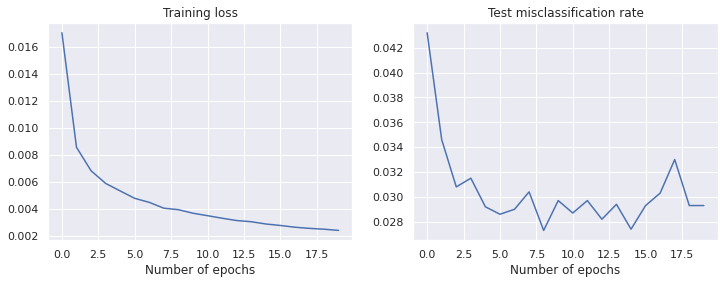

In [15]:
# I train a net with L2 loss for comparison
net = MLP()
# I use my loss function because nn.MSELoss expects one-hot encoding
loss = L1_loss(net, L1_coef=0.)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

We were able to achive a baseline error rate on the test set of almost 2.75% at epoch 8, after that the training error keeps decreasing but the validation accuracy doesn't however the accuracy doesn't increase by a lot after this minima, in a certain sense the model begins to overfit the train set but at the same time keeps the general structure of the data which allows to keep the test error rate under control

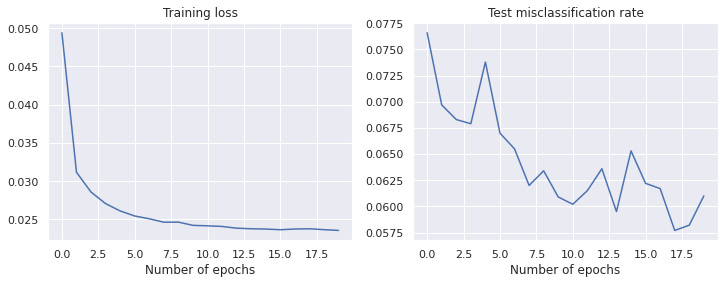

In [13]:
# Testing L1 loss
net = MLP()
loss = L1_loss(net, L1_coef=1e-4)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

We see that L1 regularization with $\lambda=10^{-4}$ doesn't help the training at all, the test misclassification rate is quite wiggly and we both need more epochs to reach a "good" minima and the minima found is worse than simply using L2 loss, below we retry with a smaller $\lambda$ 

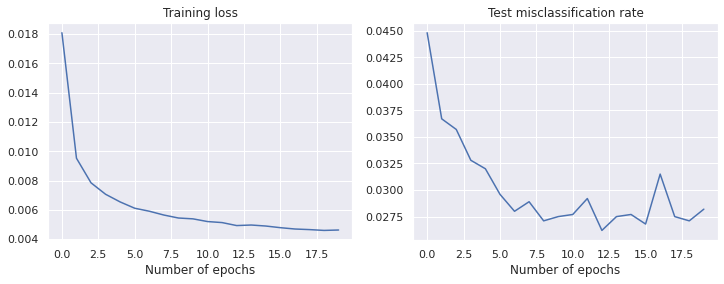

In [14]:
# Testing L1 loss
net = MLP()
loss = L1_loss(net, L1_coef=1e-6)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

With $\lambda=10^{-6}$ we get a much better result, we were able to achieve a minima of about 2.75% at epoch 8, like with plain L2 loss, then the misclassification rate sorts of flattens out

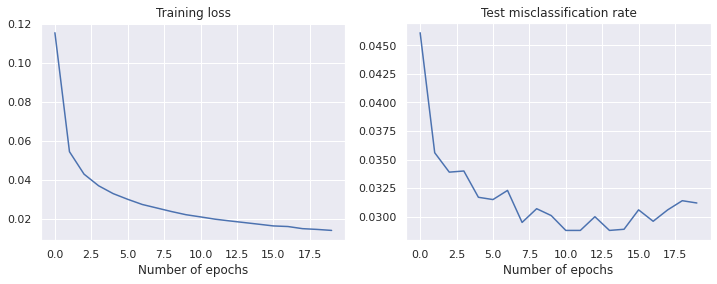

In [10]:
# Testing CCQL loss
net = MLP()
loss = CCQL()
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

In this problem CCQL doesn't seem to help, we used $\omega=2$ as the correct class bias parameter, this value is the one suggested in the paper: $\omega=\sqrt{K-1}-1$ with $K$: number of classes

## Testing early stopping

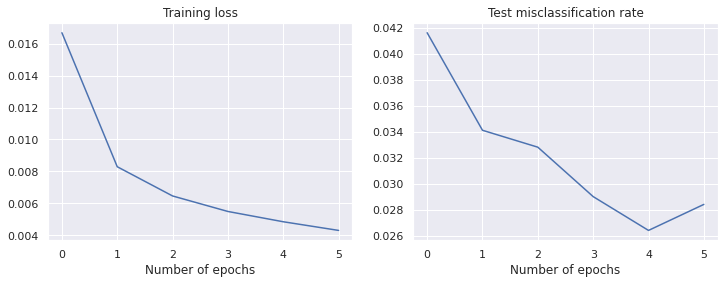

In [11]:
# Testing the first class of early stopping rules
net = MLP()
loss = L1_loss(net, L1_coef=0.)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy,
                                       stopping_criterion=stop_by_threshold())
clear_output()

plot_train_test(train_losses, test_losses)

With the first class of early stopping criteria training stops after 5 epochs and we got a very good minima of about 2.75% test misclassification rate. Obviously this is a lucky case because as we saw above that a minima like this occurs at about 8 epochs, this highlights the benefits of early stopping: we were able to save 14 epochs, or about 70% of the training time.  
However note that if we were to apply this criteria to the first example we would miss the minima at epoch 8, this could be avoided by using a higher threshold, but doing this will also cause a higher training time when the minima is reached earlier

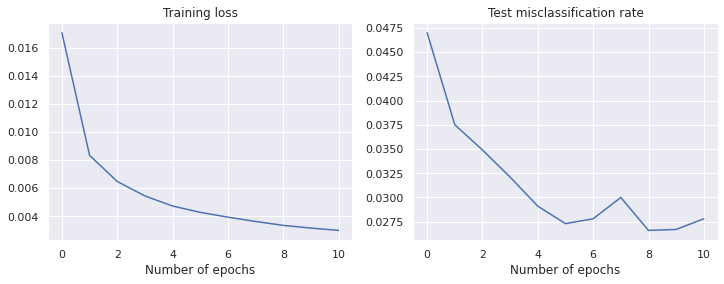

In [12]:
# Testing the first of the third class of early stopping rules
net = MLP()
loss = L1_loss(net, L1_coef=0.)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy,
                                       stopping_criterion=stop_by_increase())
clear_output()

plot_train_test(train_losses, test_losses)

Finally we tested the third class of early stopping criteria, in particular $UP_1$ with $k=5$, in this case training stops after 10 epochs so we saved about half of the training time, this is a more robust early stopping criteria that would be also able to find the minima in the first example.